In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import math
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
pylab.rcParams['figure.figsize'] = (12, 8)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def tsmom(data,months):
    vol=pd.rolling_std(data.pct_change(),24)*math.sqrt(12)
    signal=data/data.shift(months)-1
    signal = signal /abs(signal)
    position=signal / vol 
    return position

def calc_pnl(position,data):
    return position*data.pct_change().shift(1)

def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

def ew_portfolio_pnl(pnl):
    return pnl.divide(pnl.count(axis=1),axis=0).sum(axis=1)

In [392]:
data=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='last')
markets=pd.read_csv('contracts.csv',index_col=0)
volume=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
fx=pd.read_csv('currency.csv',index_col=0,parse_dates=['DATE'])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


In [16]:
data=data.dropna(axis=1)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()
  from IPython.kernel.zmq import kernelapp as app


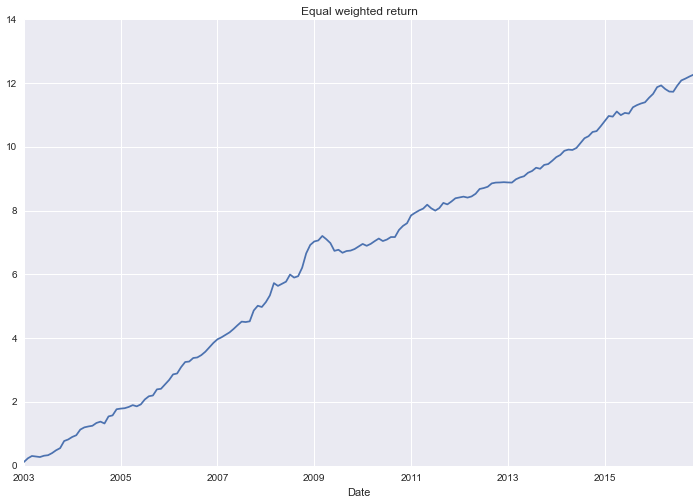

In [393]:
pos=tsmom(data,12)
pnl=calc_pnl(pos,data)
sr=calc_Sharpe(pnl)
ew_portfolio_pnl(pnl)['2003':].cumsum().plot(title='Equal weighted return')

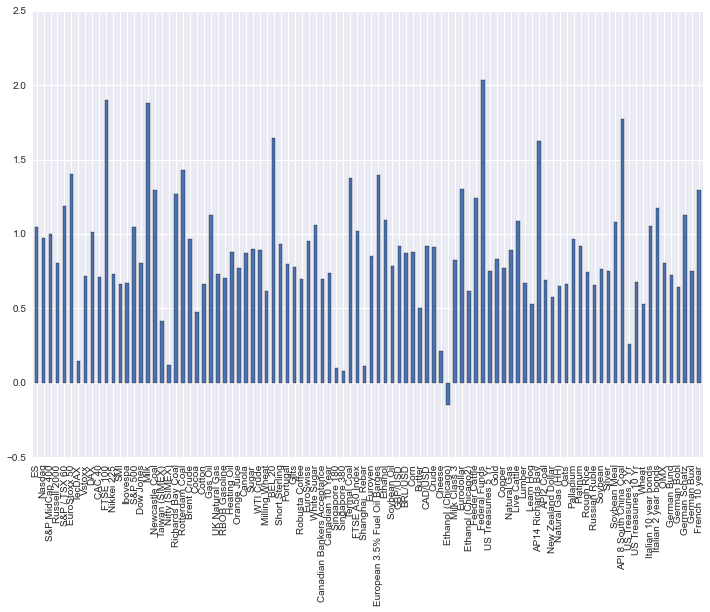

In [394]:
sr.dropna().plot(kind='bar')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()
  if __name__ == '__main__':


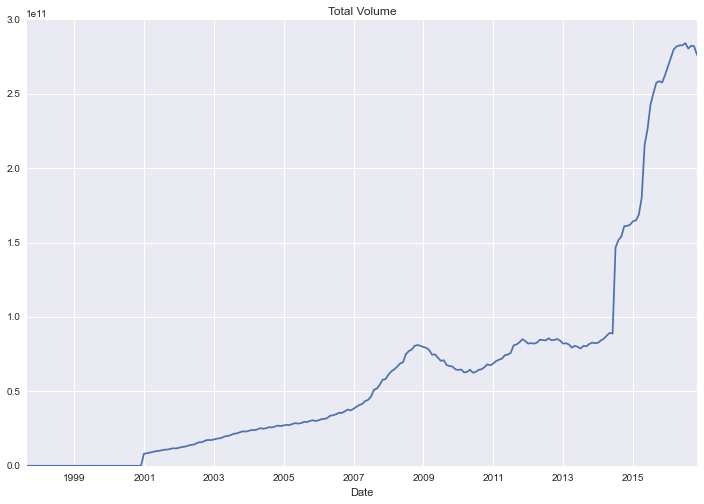

In [395]:
(pd.rolling_mean((volume*data),20).sum(axis=1)).plot(title='Total Volume')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=12).mean()
  app.launch_new_instance()


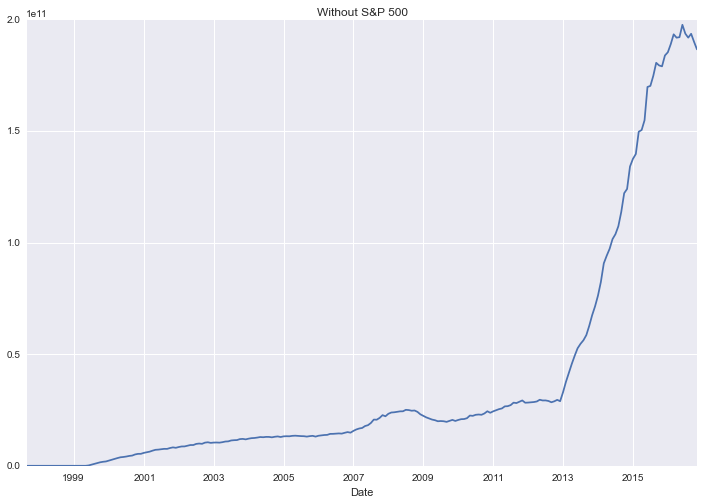

In [396]:
x=(volume*data)
x.drop('S&P 500', axis=1, inplace=True)
pd.ewma(x.sum(axis=1),12).plot(title='Without S&P 500')

# Quantile anlysis 

In [397]:
def quantile_columns(df,date,buckets,number):
    s=df.T[date].dropna()
    lower_range = number/float(buckets)
    upper_range = (number+1)/float(buckets)
    try:
        return list(s[(s>s.quantile(lower_range)) & (s<=s.quantile(upper_range))].dropna().index)
    except:
        print upper_range

In [407]:
bkts=[]
# BIG PROBELM THIS DOESN:T TAKE INTO ACCOUNT FX OR CONTRACT VALUE, NICE TRY
total_volume=data*volume
number_of_buckets=5
for y in range(2002,2016,1):
    year=str(y) + '-12-31'
    sharpes=[]
    sharpes.append(y)
    for i in range(0,number_of_buckets,1):
        mkts=quantile_columns(total_volume,year,number_of_buckets,i)
        sharpes.append(pnl.resample(rule='m',how='sum').T[year][mkts].mean())
    bkts.append(sharpes)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


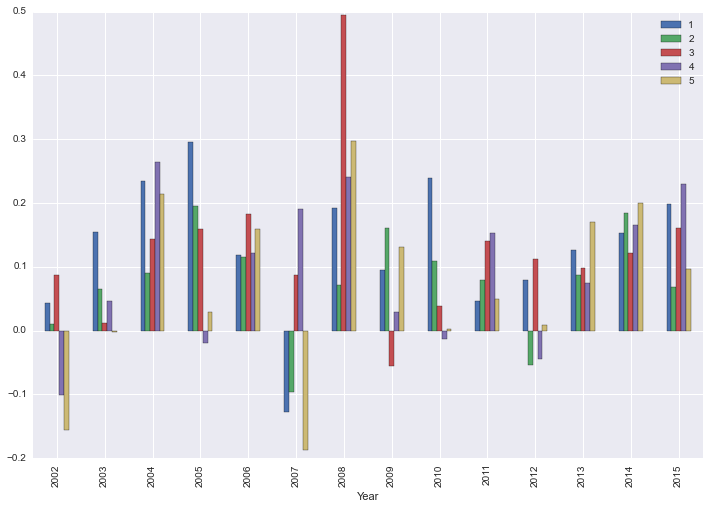

In [408]:
df=pd.DataFrame(bkts,columns=['Year','1','2','3','4','5']).set_index('Year')
df.plot(kind='bar')

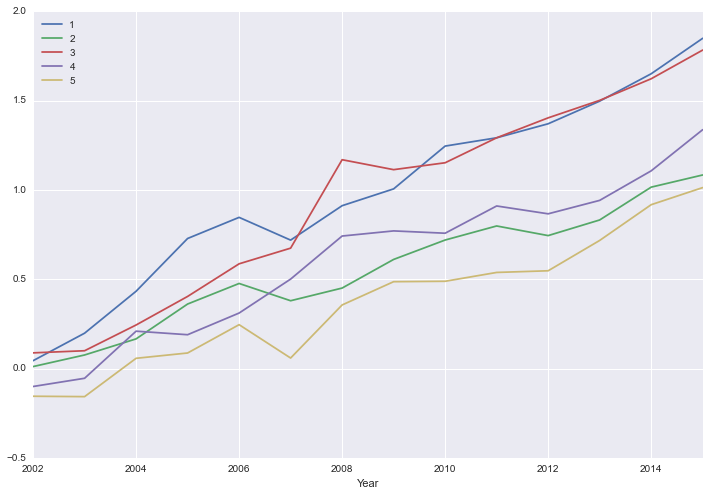

In [409]:
df.cumsum().plot()

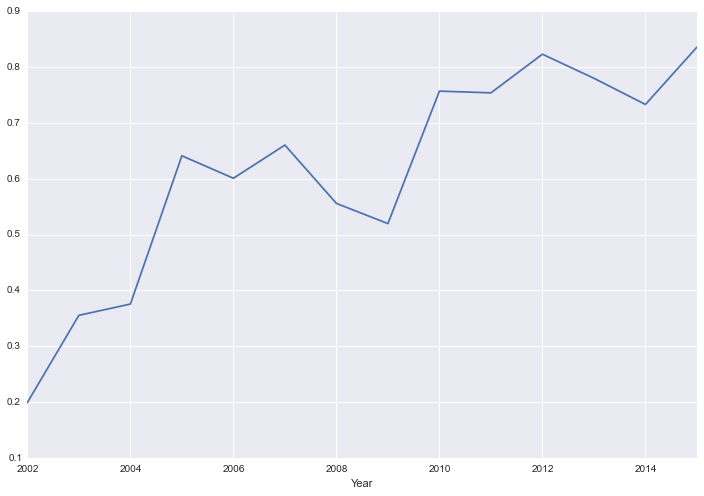

In [413]:
(df['1']-df['5']).cumsum().plot()

# Drawdown analysis compared to liquidity

In [405]:
df=pd.DataFrame()
df['SR']=sr
df['Volume']=np.log((volume*data+.01).mean())
s=pd.Series()
for x in df.T.columns:
    try:
        s[x]=markets.T[x].Sector      
    except:
        print x
df['Sector']=s
df['Drawdown'] =(((pnl.cumsum()+100) / pd.rolling_max((pnl.cumsum()+100),window=5000,min_periods=1))-1).min()

ES
RBOB Gasoline


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: FutureWarning: pd.rolling_max is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=5000,center=False).max()


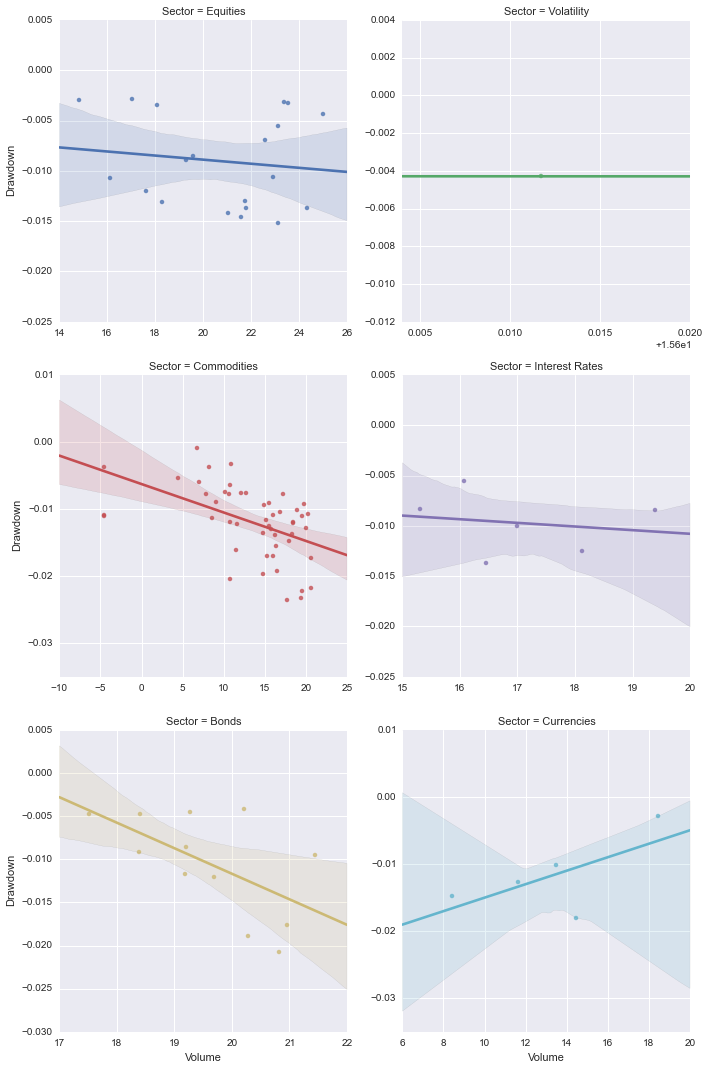

In [406]:
sns.lmplot(x='Volume',fit_reg=True,y='Drawdown',hue='Sector',sharey=False,sharex=False, 
           col='Sector',col_wrap=2,data=df.loc[df.Volume<1e10])